In [38]:
# Import libraries
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

# classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from scipy.stats import chisquare, chi2_contingency

In [39]:
# load datasest
df = pd.read_excel("./data/2nd_Dataset_IgM_Rapid_Test-ELISA_Raw_Data.xlsx", header=0, comment="#")
len(df)

106

In [40]:
# further cleanup
indexNames = df[df['Age'] == 'NS'].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

# set age to numeric
df["Age"] = df["Age"].astype(int)

# bin ages
df["Age bin"] = pd.cut(x=df['Age'], 
                       bins=[10, 20, 29, 39, 49, 59, 69, 79, 89], 
                       labels=['10s', '20s', '30s', '40s', '50s','60s', '70s', '80s'])

# remove unwanted spaces

df[" IgM/Pos."] = df[" IgM/Pos."].str.replace(' ', '')

In [41]:
# remove empty cells
df = df.dropna(axis=0)
len(df)

87

In [42]:
# create class column
def get_class(row):
    wanted = row["lab-ID"]
    return wanted.split("-")[0]

df["status"] = df.apply(get_class, axis=1)

# create target column
def encode_symptoms(row):
    wanted = row["Symptoms"]
    if str(wanted) == "no":
        return 0
    return 1

df["target"] = df.apply(encode_symptoms, axis=1)

In [7]:
# visualize if measurements are indeed equal transformations
temp_df = df[["E-IgM/ODs", " IgM", " IgM.1"]]
temp_df.corr().style.background_gradient(cmap="Blues")

,E-IgM/ODs,IgM,IgM.1
E-IgM/ODs,1.000000,0.999248,0.961280
IgM,0.999248,1.000000,0.960344
IgM.1,0.961280,0.960344,1.000000


array([[<AxesSubplot:title={'center':'E-IgM/ODs'}>]], dtype=object)

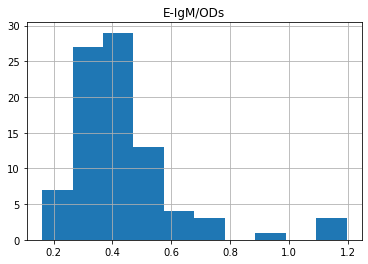

In [51]:
# visualize distributions of measurements
df.hist("E-IgM/ODs")

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

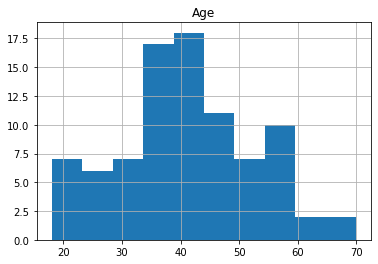

In [52]:
df.hist("Age")

<AxesSubplot:xlabel='status', ylabel='E-IgM/ODs'>

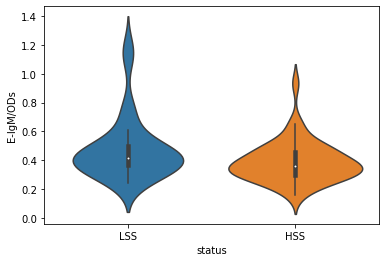

In [63]:
sns.violinplot(y="E-IgM/ODs", x="status", data=df)

<AxesSubplot:xlabel='Age bin', ylabel='E-IgM/ODs'>

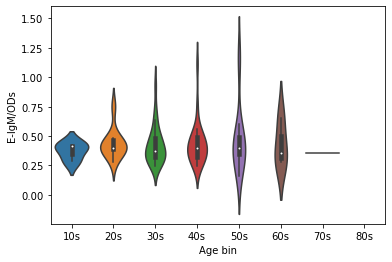

In [64]:
sns.violinplot(y="E-IgM/ODs", x="Age bin", data=df)

<AxesSubplot:xlabel='Gender', ylabel='count'>

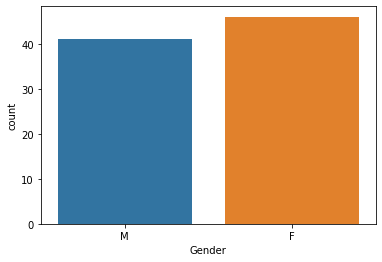

In [76]:
sns.countplot(x="Gender", data=df)

<AxesSubplot:xlabel='Age bin'>

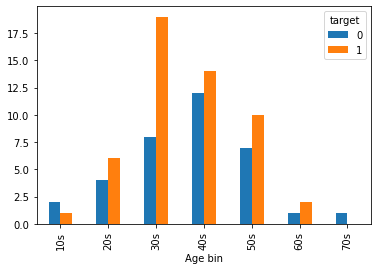

In [80]:
pd.crosstab(df["Age bin"], df["target"]).plot(kind="bar")

<AxesSubplot:xlabel='Gender'>

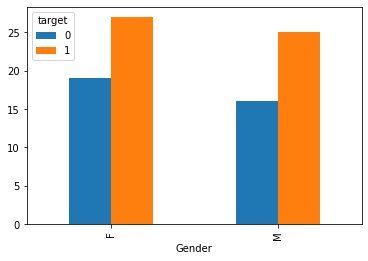

In [81]:
pd.crosstab(df["Gender"], df["target"]).plot(kind="bar")

<AxesSubplot:xlabel='status'>

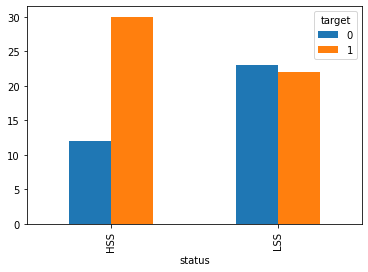

In [82]:
pd.crosstab(df["status"], df["target"]).plot(kind="bar")

<AxesSubplot:xlabel=' IgM/b-intin.'>

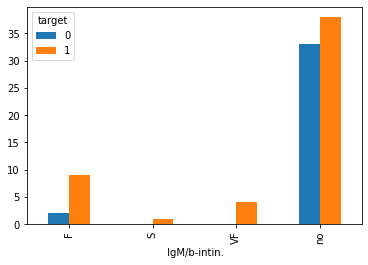

In [84]:
pd.crosstab(df[" IgM/b-intin."], df["target"]).plot(kind="bar")

<AxesSubplot:xlabel=' IgM/Pos.'>

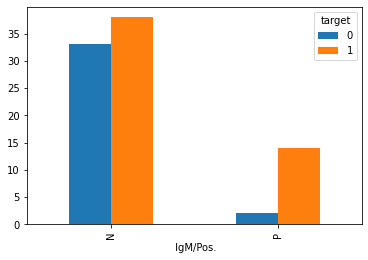

In [87]:
pd.crosstab(df[" IgM/Pos."], df["target"]).plot(kind="bar")

In [8]:
# Random forest classifier

# target 
targets = df["target"].values

# encodings

# bulk encodings

wanted_columns = ['Gender', ' IgM/Pos.', 
                  ' IgM/b-intin.', 'status',
                  'Age bin']
df_wanted = df[wanted_columns]

le = LabelEncoder()
df_wanted_le = df_wanted.apply(le.fit_transform)

ohe = OneHotEncoder()
ohe.fit(df_wanted_le)
input_df = ohe.transform(df_wanted_le).toarray()
input_df.shape

# Generate training and test sets

X_train, X_test, y_train, y_test = train_test_split(input_df,
                                                    targets,
                                                    random_state=42)

# Benchmark with dummy classifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
print("dummmy score: {}".format(dummy_clf.score(X_test, y_test)))

# Random forest model

model = RandomForestClassifier(n_jobs=2, random_state=42)
model.fit(X_train, y_train)
print("RF accuracy: {}".format(model.score(X_test, y_test)))
    

dummmy score: 0.45454545454545453
RF accuracy: 0.5454545454545454


In [25]:
# Logistic regression
from sklearn.linear_model import LogisticRegression


# only numerical variable
dependent_var = ["E-IgM/Ods"]
X_train, X_test, y_train, y_test = train_test_split(df[dependent_var].values ,
                                                    df["target"].values,
                                                    random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print("LR_numerical: {}".format(clf.score(X_test, y_test)))

# all categorical variables
new_df = pd.get_dummies(df_wanted, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(new_df.values ,
                                                    df["target"].values,
                                                    random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print("LR_categorical: {}".format(clf.score(X_test, y_test)))

# both
new_df["E-IgM/Ods"] = df["E-IgM/Ods"]
X_train, X_test, y_train, y_test = train_test_split(new_df.values ,
                                                    df["target"].values,
                                                    random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print("LR_both: {}".format(clf.score(X_test, y_test)))


LR_numerical: 0.6363636363636364
LR_categorical: 0.6818181818181818
LR_both: 0.6818181818181818


In [57]:
# t test

from scipy import stats
hss = df[df["status"] == "HSS"]["E-IgM/Ods"]
lss = df[df["status"] == "LSS"]["E-IgM/Ods"]

t_test = stats.ttest_ind(hss, lss)
t_test

Ttest_indResult(statistic=-2.222176288493547, pvalue=0.02892730300973166)